# 1. Libraries

In [5]:
%%capture
%pip install tensorflow-addons
%pip install keras-tuner tensorflow-addons

In [ ]:
# Libraries
# system packages
import os
import requests
import zipfile

# data and numerical management packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

import gensim
import gensim.downloader as gloader
from gensim.models.keyedvectors import KeyedVectors

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import keras_tuner as kt
from keras.models import Model
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, Dropout, RNN
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import Concatenate
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Remeber to set the folder where the user is located. If ran in Google Drive you can set the notebook in any folder `dir` and run `%cd MyDrive/dir`.

In [ ]:
%cd drive/MyDrive/NLP/Assignment2/Eric/

This flag serves to activate the automatic tuning process. By default is set to `False`, since all the test were done in advance by us.

In [13]:
keras_tuner = False

## 1.1 GloVe loading

In this subsection we load the GloVe pre-trained embeddings that will be used in the various models. We fixed the embedding dimension since it will not affect by much the performance. 

In [5]:
def load_glove(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
  """
  Loads a pre-trained GloVe embedding model via gensim library.

  We have a matrix that associate words to a vector of a user-defined dimension.
  """

  download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

  # check the download process
  try:
    emb_model = gloader.load(download_path)
  except ValueError as e:
    print("Generic error when loading GloVe")
    print("Check embedding dimension")
    raise e

  emb_model = gloader.load(download_path)
  return emb_model

# Parameters
embedding_dimension = 300

Note that the download will take a while.

In [6]:
try:
    embedding_model = KeyedVectors.load(f'glove_model_{embedding_dimension}')
except FileNotFoundError:
    print('[Warning] Model not found in folder, please wait...')
    embedding_model = load_glove(embedding_dimension)
    embedding_model.save(f'glove_model_{embedding_dimension}')  
    print('Download finished. Model loaded!')

# 2. Dataset


## 2.1 Downloading

First of all we need to download a pre-processed version of the **FEVER dataset**.

In [7]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    fever_data_path = os.path.join(data_path, 'fever_data.zip')
    data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(fever_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(url,
                                   params={'id': data_url_id},
                                   stream=True)
        save_response_content(response, fever_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(fever_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

## 2.2 Loading

Then we load the three splits train, val and test pairs from the csv and they will be converted in a `Pandas DataFrame`.

In [8]:
df_train = pd.read_csv('dataset/train_pairs.csv', index_col=[0])
df_val = pd.read_csv('dataset/val_pairs.csv', index_col=[0])
df_test = pd.read_csv('dataset/test_pairs.csv', index_col=[0])
df_complete = pd.concat([df_train, df_val, df_test])

As said before, the provided splits contain data in the form of pairs, that is each sample is composed in the following manner:

$$
  <claim, evidence>
$$
where both the $claim$ and the $evidence$ are strings of arbitrary size representing an evidence that supports or refutes the associated claim.


Let's see how a **claim** and an **evidence** are displayed.

In [9]:
print(f'Claims (training set): \n{df_train["Claim"][:4]}')

print()
print("=="*25)
print()

print(f'Evidences (training set): \n{df_train["Evidence"][:4]}')

Claims (training set): 
0    Chris Hemsworth appeared in A Perfect Getaway.
1                           Roald Dahl is a writer.
2                         Roald Dahl is a governor.
3       Ireland has relatively low-lying mountains.
Name: Claim, dtype: object


Evidences (training set): 
0    2\tHemsworth has also appeared in the science ...
1    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
3    10\tThe island 's geography comprises relative...
Name: Evidence, dtype: object


## 2.3 Dataset preprocessing

As we can see in the before cell, the dataset needs a bit of processing in order to be correctly fed into the network.

Let's define symbols that can be kept, other symbols that should be replaced by a whitespace. Furthermore we define also the **stopwords**, taking them from NLTK library.

In [10]:
# Using stopwords utility from nltk
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

STOPWORDS = STOPWORDS.difference(set(['not','t',"doesn't","won't","mightn't","needn't","wouldn'","wouldn't","weren't","didn't","hadn't","wasn't","don't","isn'","isn't","shan't","aren't","couldn't","mustn't","hadn'","shouldn't"]))

print(STOPWORDS)
# This characters need to be replaced by whitespaces
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@;_\t]")
# This characters should be kept
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+,]')

{'some', 'are', 'won', 'mustn', 'very', 'll', 'these', 'of', 'y', 've', 'yours', 'can', 'they', 'has', 'she', 'ourselves', 'only', 'same', 'aren', 'by', 'your', 'up', 'be', 'does', 'the', 'few', "it's", 'wasn', 'what', 'doesn', 'or', 'them', 'for', 'as', 'but', 'it', 'hasn', "haven't", 'm', 'and', 'shan', 'am', 'mightn', "you'll", 'through', 'down', 'too', "should've", 'you', 'there', 'a', 'other', 'nor', 'yourselves', 'to', 'than', 'ma', 'he', 'his', 'have', 'here', 'is', 'if', 'above', 'how', 'will', 'themselves', 'having', 'doing', 'any', 'against', 'who', 'between', 'were', 'couldn', 'wouldn', 'been', 'him', "hasn't", 'so', 'theirs', "you've", 'that', 'this', 'those', "you're", 'into', 'then', 'about', 'out', 'all', 'its', 'off', 'why', 'o', 'both', 'in', 'her', 'do', 'over', 'don', 'which', 'until', 'myself', "she's", 'after', 'whom', 'was', 'once', "that'll", 'me', 'we', 'while', 'being', 'd', 'more', 'again', 'hers', 'i', 'herself', 'needn', 'on', 'with', 'before', 'ain', 'didn'

Preprocessing functions:

In [11]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_brackets(text: str)-> str:
  return re.sub(r'-\w*-','',text)

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    """
    Removes any stopword.
    """
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def digit(text: str) -> str:
    """
    Removes any decimal digit([0-9]).
    """
    return re.sub(r'\d','',text)

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: 'This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip('')

def remove_duplicates(text: str) -> str:
    """
    Removes duplicate words. 
    """
    return (' '.join(dict.fromkeys(text.split(' '))))

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          replace_brackets,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          digit,
                          remove_duplicates,
                          strip_text
                          ]


def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

Now we apply the defined methods to the claims and evidences to remove unwanted pieces of text. We can see now how this pre-processing has affected some claims and evidences.

In [12]:
# Pre-processing

print('Pre-processing text...')

print("Claim")

print()
print('[Debug] Before :\n{}'.format(df_train.Claim[:4]))
print()

# Replace each sentence with its pre-processed version
df_train['Claim'] = df_train['Claim'].apply(lambda txt: text_prepare(txt))

print('[Debug] After :\n{}'.format(df_train.Claim[:4]))
print()

print("=="*25)
print()
print("Evidence")

print()
print('[Debug] Before :\n{}'.format(df_train.Evidence[:4]))
print()

# Replace each sentence with its pre-processed version
df_train['Evidence'] = df_train['Evidence'].apply(lambda txt: text_prepare(txt))

print('[Debug] After :\n{}'.format(df_train.Evidence[:4]))
print()


print("Pre-processing completed!")  

Pre-processing text...
Claim

[Debug] Before :
0    Chris Hemsworth appeared in A Perfect Getaway.
1                           Roald Dahl is a writer.
2                         Roald Dahl is a governor.
3       Ireland has relatively low-lying mountains.
Name: Claim, dtype: object

[Debug] After :
0    chris hemsworth appeared perfect getaway
1                           roald dahl writer
2                         roald dahl governor
3       ireland relatively lowlying mountains
Name: Claim, dtype: object


Evidence

[Debug] Before :
0    2\tHemsworth has also appeared in the science ...
1    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
3    10\tThe island 's geography comprises relative...
Name: Evidence, dtype: object

[Debug] After :
0     hemsworth also appeared science fiction actio...
1     roald dahl langpronrold dl , ul september nov...
2     roald dahl langpronrold dl , ul september nov...
3     island geography compri

Apply the processing functions to all the dataset.

In [13]:
#Text Pre-processing on Test set.
df_test['Claim'] = df_test['Claim'].apply(lambda txt: text_prepare(txt))
df_test['Evidence'] = df_test['Evidence'].apply(lambda txt: text_prepare(txt))

#Text Pre-processing on Validation set.
df_val['Claim'] = df_val['Claim'].apply(lambda txt: text_prepare(txt))
df_val['Evidence'] = df_val['Evidence'].apply(lambda txt: text_prepare(txt))

A quick look to the preprocessed `DataFrame`.

In [14]:
df_test

,Claim,Evidence,ID,Label
0,anxiety linked physical symptoms,"furthermore , anxiety linked physical symptom...",16387,SUPPORTS
1,firefox application,mozilla firefox simply free opensource web br...,6,SUPPORTS
2,keeganmichael key played president barack obam...,", key appeared white house correspondents din...",16392,SUPPORTS
3,google search find stock quotes,"include synonyms , weather forecasts time zon...",16394,SUPPORTS
4,good day die hard directed solely ridley scott,"film directed john moore written skip woods ,...",98315,REFUTES
...,...,...,...,...
7184,scandal american band,scandal american rock band s fronted patty sm...,16378,SUPPORTS
7185,henry cavill played superman,cavill gained prominence international fame p...,143046,SUPPORTS
7186,africa cup nations friendly global soccer exhi...,"africa cup nations , officially coupe dafriqu...",16382,REFUTES
7187,ron dennis owner catering company thats based ...,"absolute taste , londonbased catering company",147455,SUPPORTS


# 3. Dataset Preparation and Conversion

In this section we futher proceed on the pipeline by preparing the data. In order to deal in a more efficent way with data let's convert them from `DataFrame` to lists.

In [15]:
claims_train = list(df_train.Claim.values) 
evidences_train = list(df_train.Evidence.values)
labels_train = list(df_train.Label.values) 

claims_val = list(df_val.Claim.values) 
evidences_val = list(df_val.Evidence.values)
labels_val = list(df_val.Label.values) 

claims_test = list(df_test.Claim.values) 
evidences_test = list(df_test.Evidence.values)
labels_test = list(df_test.Label.values) 

## 3.1 Tokenization

We decided to keep one unique vocabulary for both the claims and the evidences using the Tokenizer provided by Keras. Furhtermore the vocabulary is computed incrementally by firstly fitting on the train then to the validation set, finally on the test set.

In [16]:
# Initialize Tokenizer
word_tokenizer = Tokenizer()

# Fit on Train split, updating the internal vocab
word_tokenizer.fit_on_texts(claims_train)
word_to_idx_train = word_tokenizer.word_index
print(f'[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: {len(word_to_idx_train)}')

word_tokenizer.fit_on_texts(evidences_train)
word_to_idx_train = word_tokenizer.word_index
print(f'[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: {len(word_to_idx_train)}')

# Fit on Validation split, updating the internal vocab
word_tokenizer.fit_on_texts(claims_val)
word_tokenizer.fit_on_texts(evidences_val)
word_to_idx_val = word_tokenizer.word_index

# Fit on Test split, updating the internal vocab
word_tokenizer.fit_on_texts(claims_test)
word_tokenizer.fit_on_texts(evidences_test)
word_to_idx_test = word_tokenizer.word_index

# After we have updated all the internal vocabularies we encode the claims and the evidences
# NOTE: We do this after the fitting in order to have all the indexes coherent
# NOTE: we probably don't need these encodings considering that after we have to do the encoding on the pairs
claims_train_encoded = word_tokenizer.texts_to_sequences(claims_train)
evidences_train_encoded = word_tokenizer.texts_to_sequences(evidences_train)


print()

claims_val_encoded = word_tokenizer.texts_to_sequences(claims_val)
evidences_val_encoded = word_tokenizer.texts_to_sequences(evidences_val)
print(f'[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: {len(word_to_idx_val)}')
print(f'[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: {len(word_to_idx_val)}')

print()

claims_test_encoded = word_tokenizer.texts_to_sequences(claims_test)
evidences_test_encoded = word_tokenizer.texts_to_sequences(evidences_test)
print(f'[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: {len(word_to_idx_test)}')
print(f'[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: {len(word_to_idx_test)}')

word_to_idx = word_to_idx_test
idx_to_word = word_tokenizer.index_word
word_index = word_tokenizer.word_index

[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: 19010
[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: 34564

[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: 36270
[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: 36270

[Debug] After fitting the Tokenizer on the claims (training) the vocab size is: 38220
[Debug] After fitting the Tokenizer on the evidences (training) the vocab size is: 38220


Let's visualize the tokenized sentences.

In [17]:
print("Claim")
print('[Debug] Before tokenization:\n{}'.format(claims_train[:5]))
print()

print("Evidence")
print('[Debug] After tokenization:\n{}'.format(claims_train_encoded[:5]))
print()

Claim
[Debug] Before tokenization:
['chris hemsworth appeared perfect getaway', 'roald dahl writer', 'roald dahl governor', 'ireland relatively lowlying mountains', 'ireland not relatively lowlying mountains']

Evidence
[Debug] After tokenization:
[[247, 2148, 69, 1098, 5530], [5075, 4267, 82], [5075, 4267, 744], [540, 4268, 16984, 1192], [540, 34, 4268, 16984, 1192]]



In [18]:
# Like said before this is made by both the claims and the evidences
print(f'Terms in the training set: {len(word_to_idx_train)}')
print(f'Terms in the train + validation set: {len(word_to_idx_val)}')
print(f'Terms in the train + validation + test set: {len(word_to_idx_test)}')

Terms in the training set: 34564
Terms in the train + validation set: 36270
Terms in the train + validation + test set: 38220


## 3.2 Pair encoding

Then we build the pairs `(evidence, claim, label)` using the already fit tokenizer to convert the text sequences into IDs sequences.

We will encode the pairs in the following form:
- $<\text{claim}, \text{evidence}, supports>$ into $<tokenize(\text{claim}), tokenize(\text{evidence}), 0>$
- $<\text{claim}, \text{evidence}, refutes>$ into $<tokenize(\text{claim}), tokenize(\text{evidence}), 1>$.

In [19]:
def create_pairs(claims, evidences, labels):
    '''
    Builds a pair encoding (claim, evidence, label). 
    '''
    pairs = []

    for claim, evidence, label in zip(claims, evidences, labels):
        pairs.append((claim, evidence, label))
    return pairs

In [20]:
# Generate the encoded pairs for the splits 
train_pairs = create_pairs(claims_train_encoded, evidences_train_encoded, labels_train)
train_pairs = [(pair[0], pair[1], 0) if pair[2] == 'SUPPORTS' else (pair[0], pair[1], 1) for pair in train_pairs]

val_pairs = create_pairs(claims_val_encoded, evidences_val_encoded, labels_val)
val_pairs = [(pair[0], pair[1], 0) if pair[2] == 'SUPPORTS' else (pair[0], pair[1], 1) for pair in val_pairs]

test_pairs = create_pairs(claims_test_encoded, evidences_test_encoded, labels_test)
test_pairs = [(pair[0], pair[1], 0) if pair[2] == 'SUPPORTS' else (pair[0], pair[1], 1) for pair in test_pairs]

print(f'\nEncoded pairs generated (Claim, Evidence, Support): \n{train_pairs[:5]}')


Encoded pairs generated (Claim, Evidence, Support): 
[([247, 2148, 69, 1098, 5530], [2148, 15, 69, 96, 67, 136, 1, 119, 1111, 122, 381, 1098, 5530, 151, 36, 9847, 985, 12706, 1283, 427, 3060, 95, 404, 743, 392, 373, 21, 5000], 0), ([5075, 4267, 82], [5075, 4267, 19737, 8185, 19738, 64, 78, 45, 512, 426, 114, 82, 947, 139, 2371, 1039], 0), ([5075, 4267, 744], [5075, 4267, 19737, 8185, 19738, 64, 78, 45, 512, 426, 114, 82, 947, 139, 2371, 1039], 1), ([540, 4268, 16984, 1192], [184, 2680, 3210, 4268, 16984, 1192, 3919, 246, 3877, 115, 15622, 2846, 7302, 6668, 540], 0), ([540, 34, 4268, 16984, 1192], [184, 2680, 3210, 4268, 16984, 1192, 3919, 246, 3877, 115, 15622, 2846, 7302, 6668, 540], 1)]


## 3.3 OOV words

We have a vocabulary now so we can check the Out-of-Vocabulary (OOV) words:

In [21]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - set of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return oov

... and we can count how much they are with respect to the words present in the vocabulary.

In [22]:
word_listing = list(word_tokenizer.word_index.keys())
oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms (training + validation + test): {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(set(word_listing))))

Total OOV terms (training + validation + test): 6589 (0.17%)


In [23]:
word_listing_train = list(word_to_idx_train.keys())
oov_terms_train = check_OOV_terms(embedding_model, word_listing_train)

print("Total training OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_train), float(len(oov_terms_train)) / len(set(word_listing_train))))

word_listing_val = list(word_to_idx_val.keys())                             # extract all the terms present in the train and val set
oov_terms_val = check_OOV_terms(embedding_model, word_listing_val)          # oov words from both the previous sets
oov_terms_val = oov_terms_val - oov_terms_train                             # remove the terms already considered

print("Total validation OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_val), float(len(oov_terms_val)) / len(set(word_listing_val))))

word_listing_test = list(word_to_idx_test.keys())
oov_terms_test = check_OOV_terms(embedding_model, word_listing_test)
oov_terms_test = oov_terms_test - oov_terms_val - oov_terms_train

print("Total test OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_test), float(len(oov_terms_test)) / len(set(word_listing_test))))

assert oov_terms_train.intersection(oov_terms_val, oov_terms_test) == set()

Total training OOV terms: 5616 (0.16%)
Total validation OOV terms: 456 (0.01%)
Total test OOV terms: 517 (0.01%)


We can see that the total number of OOV words is under `0.2%`, which is indeed a small number overall. This means that we can further build the embedding matrix by assigning to the OOV words a random vector uniformly sampled.

## 3.4 Matrix building 

A fundamental step is to build a matrix $M_{i} \in \mathbb{R}^{V\times d}$, where at each word, indexed at row $i$, is associated an embedding vector of size $d=300$. As mentioned earlier, if a word $i$ is not in GloVe then we assign it a r.andom vector $v \in \mathbb{R}^d$ uniformly sampled in the range $[-\frac{1}{10}, \frac{1}{10}]$.

In [24]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    oov_count = 0

    # For each word which is not present in the vocabulary we assign a random vector, otherwise we take the GloVe embedding
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            oov_count += 1
            # embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            embedding_vector = np.random.uniform(low=-0.1, high=0.1, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
    
    print(f'\n[Debug] {oov_count} OOV words found!')
    return embedding_matrix

We then build the matrix and add the padding to the vocabulary, since it will be also considered by the network. Let's visualize the shapes if all seems right.

In [25]:
# Add to vocabulary a special entry for the padding   
word_tokenizer.word_index['__PAD__'] = 0
word_tokenizer.index_word[0] = '__PAD__'

embedding_matrix = build_embedding_matrix(embedding_model=embedding_model,
                                          word_to_idx=word_to_idx,
                                          vocab_size=len(word_tokenizer.word_index),
                                          embedding_dimension=embedding_dimension)

print(f'[Debug] Embedding matrix shape (pad value included): {embedding_matrix.shape}') 

100%|██████████| 38221/38221 [00:00<00:00, 81407.04it/s]


[Debug] 6590 OOV words found!
[Debug] Embedding matrix shape (pad value included): (38221, 300)


## 3.5 Padding

First we make an analysis of the indivual lenght of the evidences and the claims present in the dataset.


In [26]:
claims_train_encoded = [pair[0] for pair in train_pairs]
evidences_train_encoded = [pair[1] for pair in train_pairs]

claims_val_encoded = [pair[0] for pair in val_pairs]
evidences_val_encoded = [pair[1] for pair in val_pairs]

claims_test_encoded = [pair[0] for pair in test_pairs]
evidences_test_encoded = [pair[1] for pair in test_pairs]

lenght_train_claim = [len(claims) for claims in claims_train_encoded]
print("Lenght of longest sentence in the Train set of claim: {}".format(np.max(lenght_train_claim)))
print("Mean length in for sentences in the Train set of claim: {}\n".format(np.mean(lenght_train_claim)))

lenght_train_evidence = [len(evd) for evd in evidences_train_encoded]
print("Lenght of longest sentence in the Train set of evidence: {}".format(np.max(lenght_train_evidence)))
print("Mean length in for sentences in the Train set of evidence: {}\n".format(np.mean(lenght_train_evidence)))

Lenght of longest sentence in the Train set of claim: 51
Mean length in for sentences in the Train set of claim: 5.141596845736816

Lenght of longest sentence in the Train set of evidence: 89
Mean length in for sentences in the Train set of evidence: 16.109076720880566



In [27]:
lenght_val_claim = [len(claims) for claims in claims_val_encoded]
print("Lenght of longest sentence in the Val set of claim: {}".format(np.max(lenght_val_claim)))
print("Mean length in for sentences in the Val set of claim: {}\n".format(np.mean(lenght_val_claim)))

lenght_val_evidence = [len(evd) for evd in evidences_val_encoded]
print("Lenght of longest sentence in the Val set of evidence: {}".format(np.max(lenght_val_evidence)))
print("Mean length in for sentences in the Val set of evidence: {}\n".format(np.mean(lenght_val_evidence)))

Lenght of longest sentence in the Val set of claim: 14
Mean length in for sentences in the Val set of claim: 5.031681786461968

Lenght of longest sentence in the Val set of evidence: 71
Mean length in for sentences in the Val set of evidence: 14.673831123517097



In [28]:
lenght_test_claim = [len(claims) for claims in claims_test_encoded]
print("Lenght of longest sentence in the Test set of claim: {}".format(np.max(lenght_test_claim)))
print("Mean length in for sentences in the Test set of claim: {}\n".format(np.mean(lenght_test_claim)))

lenght_test_evidence = [len(evd) for evd in evidences_test_encoded]
print("Lenght of longest sentence in the Test set of evidence: {}".format(np.max(lenght_test_evidence)))
print("Mean length in for sentences in the Test set of evidence: {}\n".format(np.mean(lenght_test_evidence)))

Lenght of longest sentence in the Test set of claim: 16
Mean length in for sentences in the Test set of claim: 5.232577549033246

Lenght of longest sentence in the Test set of evidence: 50
Mean length in for sentences in the Test set of evidence: 14.665461121157323



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


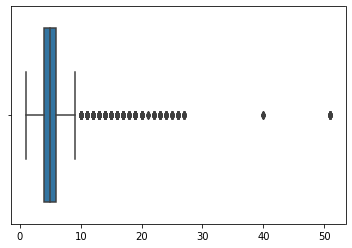

In [29]:
length_claims = lenght_train_claim + lenght_val_claim + lenght_test_claim

sns.boxplot(length_claims)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


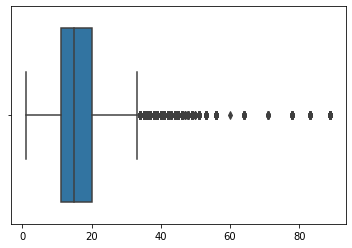

In [30]:
length_evidence = lenght_train_evidence + lenght_val_evidence + lenght_test_evidence

sns.boxplot(length_evidence)
plt.show()

Then we extract the maximum values for every subset of data and find between them the maximum value for the padding. We decide to discard the sentences which have length in the `0.0003` percentile.

In [31]:
max_length_claim = int(np.quantile(length_claims, 0.9997))

length = []
for idx, seq in enumerate(claims_train_encoded):
  length.append(len(seq))

print('Training Set:')
print(f'Mean length: {np.mean(length):.2f}')
print(f'Max length: {np.max(length)}')
print(f'Number of sentences with length greater than {max_length_claim}: {np.sum([s > max_length_claim for s in length])}')

Training Set:
Mean length: 5.14
Max length: 51
Number of sentences with length greater than 26: 36


In [32]:
max_length_evidence = int(np.quantile(length_evidence, 0.9997))

length = []
for idx, seq in enumerate(evidences_train_encoded):
  length.append(len(seq))

print(f'Mean length: {np.mean(length):.2f}')
print(f'Max length: {np.max(length)}')
print(f'Number of sentences with length greater than {max_length_evidence}: {np.sum([s > max_length_evidence for s in length])}')

Mean length: 16.11
Max length: 89
Number of sentences with length greater than 83: 40


In [33]:
#Padding "pre" or "post"
max_length = 89
pad = "post"

# Train
X_train_claim = pad_sequences(claims_train_encoded, maxlen=max_length, padding=pad)
X_train_evidence = pad_sequences(evidences_train_encoded, maxlen=max_length, padding=pad)

# Validation
X_val_claim = pad_sequences(claims_val_encoded, maxlen=max_length, padding=pad) 
X_val_evidence = pad_sequences(evidences_val_encoded, maxlen=max_length, padding=pad)

# Test
X_test_claim = pad_sequences(claims_test_encoded, maxlen=max_length, padding=pad)
X_test_evidence = pad_sequences(evidences_test_encoded, maxlen=max_length, padding=pad)


print(f'X_train claim: {X_train_claim.shape}, Y_train evidence: {X_train_evidence.shape}')
print(f'X_val claim: {X_val_claim.shape}, Y_val evidence: {X_val_evidence.shape}')
print(f'X_test claim: {X_test_claim.shape}, Y_test evidence: {X_test_evidence.shape}')

X_train claim: (121740, 89), Y_train evidence: (121740, 89)
X_val claim: (7165, 89), Y_val evidence: (7165, 89)
X_test claim: (7189, 89), Y_test evidence: (7189, 89)


## 3.6 Categorical

We extract the labels from the data, and one-hot encode them. Then we have completed the data pipeline and we are ready to provide some model definition.

In [34]:
labels_train_encoded = [pair[2] for pair in train_pairs]
labels_val_encoded = [pair[2] for pair in val_pairs]
labels_test_encoded = [pair[2] for pair in test_pairs]

Y_train = to_categorical(labels_train_encoded)
Y_val = to_categorical(labels_val_encoded)
Y_test = to_categorical(labels_test_encoded)

print(f'Y_train: {Y_train.shape}')
print(f'Y_val: {Y_val.shape}')
print(f'Y_test: {Y_test.shape}')

Y_train: (121740, 2)
Y_val: (7165, 2)
Y_test: (7189, 2)


# 4. Model Definition

To ease the organization we define some dictionaries that contain the configurations and the compilation info. The data contained into the configuration dictionary could be also used in the hyperparameter tuning.

In [35]:
config_info = {
    'enc_units': 300,
    'classification_units': 128,
    # 'merge_mode': "concat",
    'merge_mode': "sum",
    #'merge_mode': "average",
    'cosine_similarity': False,
    'dropout_rate': .3,
    'regularizer': 1e-2,
}

compile_info = {
    'loss': keras.losses.BinaryCrossentropy(from_logits=False),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
}

## 4.1 Model 1: RNN taking last state

First of all we create the model by exploiting the functional API from Keras, that is we define a building function for the first model. We will create a different building method in order to generate all the models. To get more information on the architecture please read the report. 



In [36]:
def build_model_1(
    embedding_matrix,
    max_pad_len,
    config_info: Dict,
    compile_info: Dict):
  """
  Build the model 1. See the report for more information

  Args:
    embedding_matrix : a pre-computed embedding matrix.
    max_pad_len: the maximum length of the sequences.
    config_info: a dictionary containing the info related to the model configuration
    compile_info: a dictionary containing the info related to the compiling

  Returns:
    model: a keras model built on the configuration given
  """

  assert config_info["merge_mode"] in ["concat", "sum", "average"]

  # Input layers
  claim_input = keras.Input(shape=(max_pad_len, ), name='claim')
  evidence_input = keras.Input(shape=(max_pad_len, ), name='evidence')

  # Embedding layers
  claim_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='claim_embedding'
  )(claim_input)

  evidence_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='evidence_embedding'
  )(evidence_input)

  # Encoding layers: to produce the Sentence Embeddings
  claim_encoding = Bidirectional(LSTM(units=config_info['enc_units'],
                                      return_sequences=False,
                                      kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                                      dropout=config_info['dropout_rate'],
                                      name='claim_encoding'))(claim_embedding)
  
  evidence_encoding = Bidirectional(LSTM(units=config_info['enc_units'],
                          return_sequences=False,
                          kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                          dropout=config_info['dropout_rate'],
                          name='evidence_encoding'))(evidence_embedding)

  # Merge layer
  if(config_info['merge_mode'] == 'average'):
    merged = tf.keras.layers.Average()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'sum'):
    merged = tf.keras.layers.Add()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'concat'):
    merged = tf.keras.layers.Concatenate(axis=1)([claim_encoding, evidence_encoding])

  if(config_info['cosine_similarity'] == True):
    cosine_similarity = keras.layers.Dot(axes=1, normalize=True, name='cosine_similarity')([claim_encoding, evidence_encoding])
    merged = Concatenate(axis=1)([merged, cosine_similarity])

  fc1 = Dense(units=config_info['classification_units'], 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC1')(merged)

  # Dropout layer
  fc1 = Dropout(config_info['dropout_rate'])(fc1)

  fc2 = Dense(units=config_info['classification_units']*2, 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC2')(fc1)

  # Dropout layer
  classification_input = Dropout(config_info['dropout_rate'])(fc2)

  # Classification layers
  output = Dense(units=2, 
                 activation='softmax',
                 kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                 name='output')(classification_input)                

  model = Model(inputs=[claim_input, evidence_input], outputs=output, name='RNN_last_state')
  model.compile(**compile_info)
  return model

To build the model simply call the `build_model_1()` method.

In [37]:
model_1 = build_model_1(embedding_matrix, max_length, config_info, compile_info)

Let's visualize the shapes to see if all the shapes are as expected.

In [38]:
model_1.summary()

Model: "RNN_last_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 89)]         0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 89)]         0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 89, 300)      11466300    ['claim[0][0]']                  
                                                                                                  
 evidence_embedding (Embedding)  (None, 89, 300)     11466300    ['evidence[0][0]']               
                                                                                     

In [39]:
#keras.utils.plot_model(model_1, "RNN_last_state.png")

## 4.2 Model 2 : RNN with mean of generated states

In [40]:
def build_model_2(
    embedding_matrix,
    max_pad_len,
    config_info: Dict,
    compile_info: Dict):
  """
  Build the model 1. See the report for more information

  Args:
    embedding_matrix : a pre-computed embedding matrix.
    max_pad_len: the maximum length of the sequences.
    config_info: a dictionary containing the info related to the model configuration
    compile_info: a dictionary containing the info related to the compiling

  Returns:
    model: a keras model built on the configuration given
  """

  assert config_info["merge_mode"] in ["concat", "sum", "average"]

  # Input layers
  claim_input = keras.Input(shape=(max_pad_len, ), name='claim')
  evidence_input = keras.Input(shape=(max_pad_len, ), name='evidence')

  # Embedding layers
  claim_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='claim_embedding'
  )(claim_input)

  evidence_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='evidence_embedding'
  )(evidence_input)

  # Encoding layers: to produce the Sentence Embeddings
  claim_encoding = Bidirectional(LSTM(units=config_info['enc_units'],
                                      return_sequences=True,
                                      kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                                      name='claim_encoding'))(claim_embedding)
  
  evidence_encoding = Bidirectional(LSTM(units=config_info['enc_units'],
                          return_sequences=True,
                          kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                          name='evidence_encoding'))(evidence_embedding)

  # Since now the Bi-LSTM produces an output of the shape (None, max_pad_len, units) in order
  # to collapse the second dimension we average the obtained values 
  claim_encoding = tf.reduce_mean(claim_encoding, axis=1)
  evidence_encoding = tf.reduce_mean(evidence_encoding, axis=1)

  # Merge layer
  if(config_info['merge_mode'] == 'average'):
    merged = tf.keras.layers.Average()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'sum'):
    merged = tf.keras.layers.Add()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'concat'):
    merged = tf.keras.layers.Concatenate(axis=1)([claim_encoding, evidence_encoding])

  if(config_info['cosine_similarity'] == True):
    cosine_similarity = keras.layers.Dot(axes=1, normalize=True, name='cosine_similarity')([claim_encoding, evidence_encoding])
    merged = Concatenate(axis=1)([merged, cosine_similarity])

  fc1 = Dense(units=config_info['classification_units'], 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC1')(merged)

  # Dropout layer
  fc1 = Dropout(config_info['dropout_rate'])(fc1)

  fc2 = Dense(units=config_info['classification_units']*2, 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC2')(fc1)

  # Dropout layer
  classification_input = Dropout(config_info['dropout_rate'])(fc2)

  # Classification layers
  output = Dense(units=2, 
                 activation='softmax',
                 kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                 name='output')(classification_input)     

  model = Model(inputs=[claim_input, evidence_input], outputs=output, name='RNN_mean_state')
  model.compile(**compile_info)
  return model

In [41]:
model_2 = build_model_2(embedding_matrix, max_length, config_info, compile_info)

In [42]:
model_2.summary()

Model: "RNN_mean_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 89)]         0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 89)]         0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 89, 300)      11466300    ['claim[0][0]']                  
                                                                                                  
 evidence_embedding (Embedding)  (None, 89, 300)     11466300    ['evidence[0][0]']               
                                                                                     

In [43]:
#keras.utils.plot_model(model_2, "RNN_mean_state.png")

## 4.3 Model 3 : MLP

In [44]:
def build_model_3(
    embedding_matrix,
    max_pad_len,
    config_info: Dict,
    compile_info: Dict):
  """
  Build the model 1. See the report for more information

  Args:
    embedding_matrix : a pre-computed embedding matrix.
    max_pad_len: the maximum length of the sequences.
    config_info: a dictionary containing the info related to the model configuration
    compile_info: a dictionary containing the info related to the compiling

  Returns:
    model: a keras model built on the configuration given
  """

  assert config_info["merge_mode"] in ["concat", "sum", "average"]

  # Input layers
  claim_input = keras.Input(shape=(max_pad_len, ), name='claim')
  evidence_input = keras.Input(shape=(max_pad_len, ), name='evidence')

  # Embedding layers
  claim_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='claim_embedding'
  )(claim_input)

  evidence_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='evidence_embedding'
  )(evidence_input)

  # Encoding layers: to produce the Sentence Embeddings
  # Reshape of the embedded before passing them to the MLP
  # from [batch_size, max_tokens, embedding_dim] to [batch_size, max_tokens * embedding_dim]
  claim_flatten  = tf.reshape(claim_embedding, [-1, max_pad_len * embedding_dimension])
  evidence_flatten  = tf.reshape(evidence_embedding, [-1, max_pad_len * embedding_dimension])

  #MLP layers, we divide the number of units in order to reduce considerably the number of params
  claim_encoding = Dense(config_info['enc_units']//2, 
                         activation = 'relu',
                         kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                         name='claim_encoding')(claim_flatten)
  evidence_encoding = Dense(config_info['enc_units']//2, 
                            activation = 'relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                            name='evidence_encoding')(evidence_flatten)

  # Merge layer
  if(config_info['merge_mode'] == 'average'):
    merged = tf.keras.layers.Average()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'sum'):
    merged = tf.keras.layers.Add()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'concat'):
    merged = tf.keras.layers.Concatenate(axis=1)([claim_encoding, evidence_encoding])

  if(config_info['cosine_similarity'] == True):
    cosine_similarity = keras.layers.Dot(axes=1, normalize=True, name='cosine_similarity')([claim_encoding, evidence_encoding])
    merged = Concatenate(axis=1)([merged, cosine_similarity])

  fc1 = Dense(units=config_info['classification_units'], 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC1')(merged)

  # Dropout layer
  fc1 = Dropout(config_info['dropout_rate'])(fc1)

  fc2 = Dense(units=config_info['classification_units']*2, 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC2')(fc1)

  # Dropout layer
  classification_input = Dropout(config_info['dropout_rate'])(fc2)

  # Classification layers
  output = Dense(units=2, 
                 activation='softmax',
                 kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                 name='output')(classification_input)     

  model = Model(inputs=[claim_input, evidence_input], outputs=output, name='MLP')
  model.compile(**compile_info)
  return model

In [45]:
model_3 = build_model_3(embedding_matrix, max_length, config_info, compile_info)

In [46]:
model_3.summary()

Model: "MLP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 89)]         0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 89)]         0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 89, 300)      11466300    ['claim[0][0]']                  
                                                                                                  
 evidence_embedding (Embedding)  (None, 89, 300)     11466300    ['evidence[0][0]']               
                                                                                                

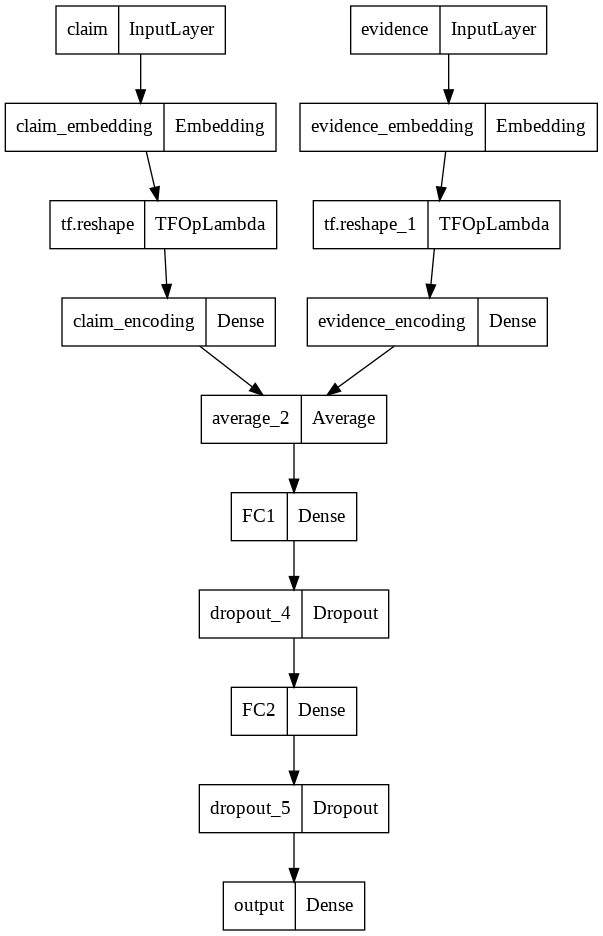

In [47]:
keras.utils.plot_model(model_3, "MLP.png")

## 4.4 Model 4 : Bag of Vector

In [48]:
def build_model_4(
    embedding_matrix,
    max_pad_len,
    config_info: Dict,
    compile_info: Dict):
  """
  Build the model 1. See the report for more information

  Args:
    embedding_matrix : a pre-computed embedding matrix.
    max_pad_len: the maximum length of the sequences.
    config_info: a dictionary containing the info related to the model configuration
    compile_info: a dictionary containing the info related to the compiling

  Returns:
    model: a keras model built on the configuration given
  """

  assert config_info["merge_mode"] in ["concat", "sum", "average"]

  # Input layers
  claim_input = keras.Input(shape=(max_pad_len, ), name='claim')
  evidence_input = keras.Input(shape=(max_pad_len, ), name='evidence')

  # Embedding layers
  claim_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='claim_embedding'
  )(claim_input)

  evidence_embedding = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = False,
      mask_zero = False,
      name='evidence_embedding'
  )(evidence_input)

  # Encoding layers: to produce the Sentence Embeddings
  # # Flatten
  # claim_flatten  = tf.reshape(claim_embedding, [-1, max_pad_len * embedding_dimension])
  # evidence_flatten  = tf.reshape(evidence_embedding, [-1, max_pad_len * embedding_dimension])

  # # Compute the mean
  # claim_encoding = tf.reduce_mean(claim_flatten, axis=-1)
  # evidence_encoding = tf.reduce_mean(evidence_flatten, axis=-1)

  # The sentence embedding will be the mean of its embeddings, this means that the 
  # the expected shape will be (None, embedding_dimension)
  claim_encoding = tf.keras.layers.GlobalAveragePooling1D()(claim_embedding)
  evidence_encoding = tf.keras.layers.GlobalAveragePooling1D()(evidence_embedding)

  # Merge layer
  if(config_info['merge_mode'] == 'average'):
    merged = tf.keras.layers.Average()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'sum'):
    merged = tf.keras.layers.Add()([claim_encoding, evidence_encoding])
  elif(config_info['merge_mode'] == 'concat'):
    merged = tf.keras.layers.Concatenate(axis=1)([claim_encoding, evidence_encoding])

  if(config_info['cosine_similarity'] == True):
    cosine_similarity = keras.layers.Dot(axes=1, normalize=True, name='cosine_similarity')([claim_encoding, evidence_encoding])
    merged = Concatenate(axis=1)([merged, cosine_similarity])

  fc1 = Dense(units=config_info['classification_units'], 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC1')(merged)

  # Dropout layer
  fc1 = Dropout(config_info['dropout_rate'])(fc1)

  fc2 = Dense(units=config_info['classification_units']*2, 
              activation='leaky_relu', 
              kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
              name='FC2')(fc1)

  # Dropout layer
  classification_input = Dropout(config_info['dropout_rate'])(fc2)

  # Classification layers
  output = Dense(units=2, 
                 activation='softmax',
                 kernel_regularizer=tf.keras.regularizers.l2(config_info['regularizer']),
                 name='output')(classification_input)     

  model = Model(inputs=[claim_input, evidence_input], outputs=output, name='BoV')
  model.compile(**compile_info)
  return model

In [49]:
model_4 = build_model_4(embedding_matrix, max_length, config_info, compile_info)

In [50]:
model_4.summary()

Model: "BoV"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim (InputLayer)             [(None, 89)]         0           []                               
                                                                                                  
 evidence (InputLayer)          [(None, 89)]         0           []                               
                                                                                                  
 claim_embedding (Embedding)    (None, 89, 300)      11466300    ['claim[0][0]']                  
                                                                                                  
 evidence_embedding (Embedding)  (None, 89, 300)     11466300    ['evidence[0][0]']               
                                                                                                

In [51]:
#keras.utils.plot_model(model_4, "BOV.png")

# 5. Training

## 5.1 Hyperparameter tuning: KerasTuner

To ease the tuning we will define a method that will build a user-specified model.

In [52]:
def build_model(embedding_matrix,
                max_pad_len,
                config_info: Dict,
                compile_info: Dict):
  if config_info['model_name'] == 'RNN_last_state':
    return build_model_1(embedding_matrix, max_pad_len, config_info, compile_info)
  elif config_info['model_name'] == 'RNN_mean_state':
    return build_model_2(embedding_matrix, max_pad_len, config_info, compile_info)
  elif config_info['model_name'] == 'MLP':
    return build_model_3(embedding_matrix, max_pad_len, config_info, compile_info) 
  elif config_info['model_name'] == 'BoV':
    return build_model_4(embedding_matrix, max_pad_len, config_info, compile_info)  

Here the code part for the automatic tuning. You do not have to run it, you can simply skip it to the results part. Still, for completeness we will report the associated snippet.

The hyperparameter space focuses on the most important paramenters, that is we let the `KerasTuner` search for the following optimal parameters:
1. the model type, in order to get the best kind of model among the ones defined,
2. the merging modality, as such we can get a better idea if one method is better than the other,
3. the dropout rate,
4. the regularizer lambda,
5. the number of units used in the models,
6. the optimizer's learning rate.

In [53]:
if keras_tuner:  
  # Max epochs for the KerasTuner
  epochs_tuning = 20

  # Batch size used
  batch_size_tuning = 128

  # tune the hyperparameters of the possible choices
  tuner = kt.Hyperband(lambda hp: build_model(embedding_matrix=embedding_matrix,
                                              max_pad_len=max_length, 
                                              config_info={
                                                  "model_name": hp.Choice('model_name', ["RNN_last_state", "RNN_mean_state", "MLP", "BoV"]),
                                                  "merge_mode": hp.Choice('merge_mode', ["concat", "sum", "average"]),
                                                  "dropout_rate": hp.Choice('dropout_rate', [0.3]),
                                                  "regularizer": hp.Choice("regularizer", [1e-3, 5e-4]),
                                                  "enc_units":  hp.Choice('units', [300, 600]),
                                                  "classification_units":  hp.Choice('units', [128]),
                                                  "cosine_similarity": True
                                              }, 
                                              compile_info={
                                                  'loss': keras.losses.BinaryCrossentropy(from_logits=False),
                                                  'optimizer': keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 5e-3])),
                                                  'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
                                              }),
                      objective=kt.Objective("val_accuracy", direction="max"),
                      max_epochs=epochs_tuning,
                      overwrite=True,
                      directory="tuner",
                      project_name="tuner_fact_checking"
                      )

  tuner.search_space_summary()

  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode="max", restore_best_weights=True)

  tuner.search({"claim": X_train_claim, "evidence": X_train_evidence}, Y_train, 
              epochs=epochs_tuning, 
              batch_size=batch_size_tuning, 
              validation_data=({"claim": X_val_claim, "evidence": X_val_evidence}, Y_val),
              callbacks=[stop_early])
  best_hps = tuner.get_best_hyperparameters()[0]

  print(f"The hyperparameter search is complete.\n" 
        f"The optimal sentence embedding mode is: {best_hps.get('model_name')}.\n" 
        f"The optimal merging mode is: {best_hps.get('merge_mode')}.\n" 
        f"The optimal regualizer rate is: {best_hps.get('regularizer')}.\n" 
        f"The optimal rate for Dropout layer is: {best_hps.get('dropout_rate')}.\n"
        f"The optimal number of units is: {best_hps.get('units')}.\n"
        f"The optimal learning rate for the optimizer is: {best_hps.get('learning_rate')}.")

## 5.2 Manual Training

This section serves to train manually each model with the parameters provided by the keras tuner, or eventually with some user-defined parameters.

In [54]:
def train_model(model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed")
    return history, model

def plot_history(hist):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    fig.suptitle('Training trends')
    axs[0].plot(hist.history['accuracy'])
    axs[0].plot(hist.history['val_accuracy'])
    axs[0].set_title("model accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title("model loss")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='best')

    # axs[2].plot(hist.history['f1_score'])
    # axs[2].plot(hist.history['val_f1_score'])
    # axs[2].set_title("model f1 score")
    # axs[2].set_ylabel('f1 score')
    # axs[2].set_xlabel('epoch')
    # axs[2].legend(['train', 'val'], loc='best')

    plt.show()

Here below the training info. If you want to train the model froms scratch set `training` to `True`, otherwise you can load some pre-trained models.

In [55]:
training_info = {
    'verbose': 1,
    'epochs': 20,
    'batch_size': 64,
    'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                patience=5,
                                                mode='max',
                                                restore_best_weights=True)],
}

models_path = "models"
training = True

### 5.2.1 Model 1 training

In [56]:
config_info_1 = {
    'enc_units': embedding_dimension,
    'classification_units': 128,
    # 'merge_mode': "concat",
    'merge_mode': "sum",
    # 'merge_mode': "average",
    'cosine_similarity': True,
    'dropout_rate': .3,
    #'regularizer': 1e-5,
    'regularizer': 1e-4,
}

compile_info_1 = {
    'loss': keras.losses.BinaryCrossentropy(from_logits=False),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
}

In [57]:
if not training:  
  # load models
  print('Loading model...')
  model_1 = tf.keras.models.load_model(os.path.join(models_path, "model_1"))
  print('Model correctly loaded.')

  # Restore history
  cols = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  history_1 = pd.read_csv(os.path.join(models_path, "history_1.csv"), usecols=cols)
else:
  history_1, model_1 = train_model(model=build_model_1(embedding_matrix, max_length, config_info_1, compile_info_1), 
                                 x_train=[X_train_claim, X_train_evidence], 
                                 y_train=Y_train,
                                 x_val=[X_val_claim, X_val_evidence], 
                                 y_val=Y_val, 
                                 training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 20, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f5a1b607210>]}
Epoch 1/20
1903/1903 [==============================] - 124s 59ms/step - loss: 0.5372 - accuracy: 0.7917 - f1_score: 0.6487 - val_loss: 0.7135 - val_accuracy: 0.6133 - val_f1_score: 0.5470
Epoch 2/20
1903/1903 [==============================] - 108s 57ms/step - loss: 0.4816 - accuracy: 0.8083 - f1_score: 0.6893 - val_loss: 0.7039 - val_accuracy: 0.6368 - val_f1_score: 0.5854
Epoch 3/20
1903/1903 [==============================] - 106s 56ms/step - loss: 0.4720 - accuracy: 0.8131 - f1_score: 0.7024 - val_loss: 0.6900 - val_accuracy: 0.6461 - val_f1_score: 0.6018
Epoch 4/20
1903/1903 [==============================] - 106s 56ms/step - loss: 0.4641 - accuracy: 0.8171 - f1_score: 0.7103 - val_loss: 0.6675 - val_accuracy: 0.6592 - val_f1_score: 0.6229
Epoch 5/20
1903/1903 [==============================] - 107s 56ms/step - loss: 0.4558 - accuracy

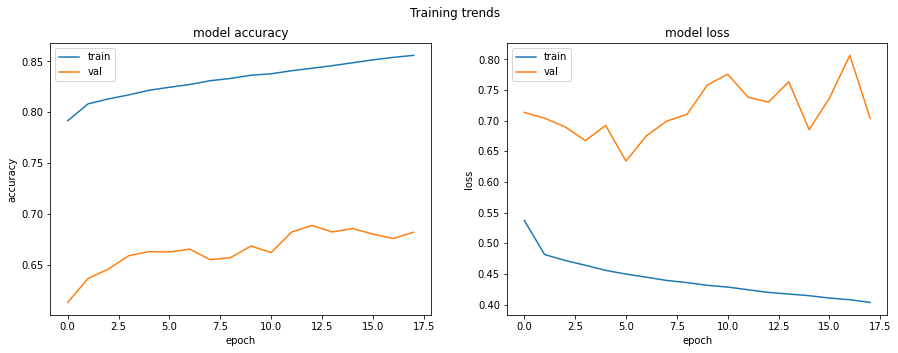

In [58]:
plot_history(history_1)

Configuration: 
- batch size: `64`,
- epochs: `18/20`,
- learning rate: `1e-3`
- encoding units: `300`
- classification units: `128`
- merge mode: `SUM`
- dropout rate: `0.3`
- cosine similarity extension: `True` 
- regularizer: `1e-4`

Obtaining at best circa `0.69` for the accuracy on the validation set.

Then we need to save the model accordingly.


In [59]:
if training:  
  model_1.save(os.path.join(models_path, "model_1"))

  # convert the history.history dict to a pandas DataFrame:     
  df_history_1 = pd.DataFrame(history_1.history) 
  with open(os.path.join(models_path, "history_1.csv"), mode="w") as file:
      df_history_1.to_csv(file)

INFO:tensorflow:Assets written to: models/model_1/assets


INFO:tensorflow:Assets written to: models/model_1/assets


### 5.2.2 Model 2 training

In [60]:
config_info_2 = {
    'enc_units': embedding_dimension,
    'classification_units': 128,
    # 'merge_mode': "concat",
    'merge_mode': "sum",
    # 'merge_mode': "average",
    'cosine_similarity': True,
    'dropout_rate': .3,
    #'regularizer': 1e-5,
    'regularizer': 1e-4,
}

compile_info_2 = {
    'loss': keras.losses.BinaryCrossentropy(from_logits=False),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
}

In [61]:
if not training:  
  # load models
  print('Loading model...')
  model_2 = tf.keras.models.load_model(os.path.join(models_path, "model_2"))
  print('Model correctly loaded.')

  # Restore history
  cols = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  history_2 = pd.read_csv(os.path.join(models_path, "history_2.csv"), usecols=cols)
else:
  history_2, model_2 = train_model(model=build_model_2(embedding_matrix, max_length, config_info_2, compile_info_2), 
                                 x_train=[X_train_claim, X_train_evidence], 
                                 y_train=Y_train,
                                 x_val=[X_val_claim, X_val_evidence], 
                                 y_val=Y_val, 
                                 training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 20, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f5a1b607210>]}
Epoch 1/20
1903/1903 [==============================] - 119s 59ms/step - loss: 0.5390 - accuracy: 0.7828 - f1_score: 0.6160 - val_loss: 0.7334 - val_accuracy: 0.6181 - val_f1_score: 0.5577
Epoch 2/20
1903/1903 [==============================] - 108s 57ms/step - loss: 0.4751 - accuracy: 0.8107 - f1_score: 0.6927 - val_loss: 0.6584 - val_accuracy: 0.6609 - val_f1_score: 0.6293
Epoch 3/20
1903/1903 [==============================] - 109s 57ms/step - loss: 0.4559 - accuracy: 0.8202 - f1_score: 0.7173 - val_loss: 0.6839 - val_accuracy: 0.6710 - val_f1_score: 0.6461
Epoch 4/20
1903/1903 [==============================] - 108s 57ms/step - loss: 0.4431 - accuracy: 0.8267 - f1_score: 0.7332 - val_loss: 0.6611 - val_accuracy: 0.6650 - val_f1_score: 0.6302
Epoch 5/20
1903/1903 [==============================] - 108s 57ms/step - loss: 0.4330 - accuracy

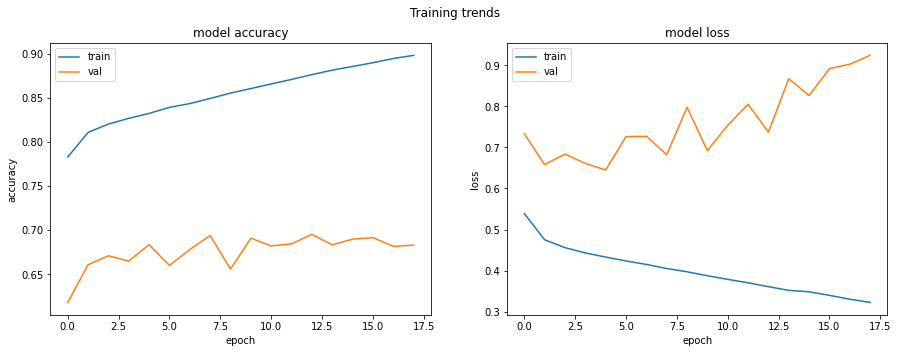

In [62]:
plot_history(history_2)

Configuration: 
- batch size: `64`,
- epochs: `14/20`,
- learning rate: `1e-3`
- encoding units: `300`
- classification units: `128`
- merge mode: `SUM`
- dropout rate: `0.3`
- cosine similarity extension: `True` 
- regularizer: `1e-4`

Obtaining at best `0.6920` accuracy on the validation set.

Then we need to save the model accordingly.


In [63]:
if training:  
  model_2.save(os.path.join(models_path, "model_2"))

  # convert the history.history dict to a pandas DataFrame:     
  df_history_2 = pd.DataFrame(history_2.history) 
  with open(os.path.join(models_path, "history_2.csv"), mode="w") as file:
      df_history_2.to_csv(file)

INFO:tensorflow:Assets written to: models/model_2/assets


INFO:tensorflow:Assets written to: models/model_2/assets


### 5.2.3 Model 3 training

In [64]:
config_info_3 = {
    'enc_units': embedding_dimension,
    'classification_units': 128,
    # 'merge_mode': "concat",
    'merge_mode': "sum",
    # 'merge_mode': "average",
    'cosine_similarity': True,
    'dropout_rate': .3,
    #'regularizer': 1e-5,
    'regularizer': 1e-4,
}

compile_info_3 = {
    'loss': keras.losses.BinaryCrossentropy(from_logits=False),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
}

In [65]:
if not training:  
  # load models
  print('Loading model...')
  model_3 = tf.keras.models.load_model(os.path.join(models_path, "model_3"))
  print('Model correctly loaded.')

  # Restore history
  cols = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  history_3 = pd.read_csv(os.path.join(models_path, "history_3.csv"), usecols=cols)
else:
  history_3, model_3 = train_model(model=build_model_3(embedding_matrix, max_length, config_info_3, compile_info_3), 
                                 x_train=[X_train_claim, X_train_evidence], 
                                 y_train=Y_train,
                                 x_val=[X_val_claim, X_val_evidence], 
                                 y_val=Y_val, 
                                 training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 20, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f5a1b607210>]}
Epoch 1/20
1903/1903 [==============================] - 18s 9ms/step - loss: 0.5612 - accuracy: 0.7693 - f1_score: 0.5862 - val_loss: 0.7304 - val_accuracy: 0.5976 - val_f1_score: 0.5414
Epoch 2/20
1903/1903 [==============================] - 18s 9ms/step - loss: 0.5137 - accuracy: 0.7867 - f1_score: 0.6363 - val_loss: 0.8323 - val_accuracy: 0.5724 - val_f1_score: 0.4772
Epoch 3/20
1903/1903 [==============================] - 16s 9ms/step - loss: 0.4997 - accuracy: 0.7901 - f1_score: 0.6437 - val_loss: 0.7874 - val_accuracy: 0.5860 - val_f1_score: 0.5050
Epoch 4/20
1903/1903 [==============================] - 15s 8ms/step - loss: 0.4915 - accuracy: 0.7930 - f1_score: 0.6499 - val_loss: 0.7288 - val_accuracy: 0.5718 - val_f1_score: 0.4757
Epoch 5/20
1903/1903 [==============================] - 16s 8ms/step - loss: 0.4865 - accuracy: 0.7952 -

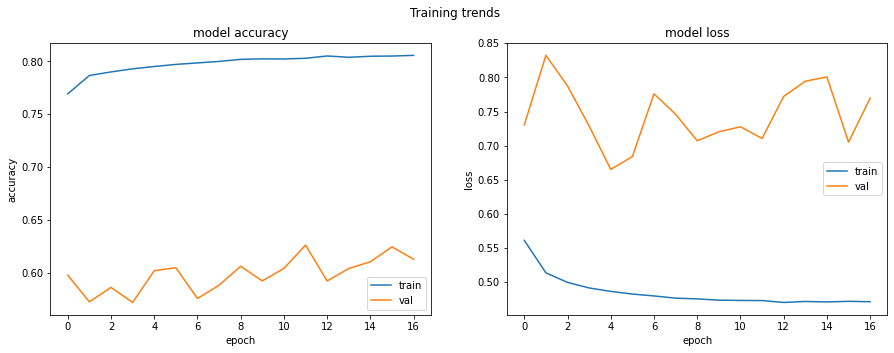

In [66]:
plot_history(history_3)

Configuration: 

- batch size: `64`,
- epochs: `06/20`,
- learning rate: `1e-3`
- encoding units: `300`
- classification units: `128`
- merge mode: `SUM`
- dropout rate: `0.3`
- cosine similarity extension: `True` 
- regularizer: `1e-4`
Obtaining at best `0.6201` accuracy on the validation set.

Then we need to save the model accordingly.


In [67]:
if training:  
  model_3.save(os.path.join(models_path, "model_3"))

  # convert the history.history dict to a pandas DataFrame:     
  df_history_3 = pd.DataFrame(history_3.history) 
  with open(os.path.join(models_path, "history_3.csv"), mode="w") as file:
      df_history_3.to_csv(file)

INFO:tensorflow:Assets written to: models/model_3/assets


INFO:tensorflow:Assets written to: models/model_3/assets


### 5.2.4 Model 4 training

In [68]:
config_info_4 = {
    'enc_units': embedding_dimension,
    'classification_units': 128,
    # 'merge_mode': "concat",
    'merge_mode': "sum",
    # 'merge_mode': "average",
    'cosine_similarity': True,
    'dropout_rate': .3,
    #'regularizer': 1e-5,
    'regularizer': 1e-4,
}

compile_info_4 = {
    'loss': keras.losses.BinaryCrossentropy(from_logits=False),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-2),
    'metrics': [keras.metrics.BinaryAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=2, threshold=0.5)]    
}

In [69]:
if not training:  
  # load models
  print('Loading model...')
  model_4 = tf.keras.models.load_model(os.path.join(models_path, "model_4"))
  print('Model correctly loaded.')

  # Restore history
  cols = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  history_4 = pd.read_csv(os.path.join(models_path, "history_4.csv"), usecols=cols)
else:
  history_4, model_4 = train_model(model=build_model_4(embedding_matrix, max_length, config_info_4, compile_info_4), 
                                 x_train=[X_train_claim, X_train_evidence], 
                                 y_train=Y_train,
                                 x_val=[X_val_claim, X_val_evidence], 
                                 y_val=Y_val, 
                                 training_info={
                                  'verbose': 1,
                                  'epochs': 20,
                                  'batch_size': 64
                                  })

Start training 
Parameters: {'verbose': 1, 'epochs': 20, 'batch_size': 64}
Epoch 1/20
1903/1903 [==============================] - 11s 5ms/step - loss: 0.5881 - accuracy: 0.7340 - f1_score: 0.4240 - val_loss: 0.8094 - val_accuracy: 0.5040 - val_f1_score: 0.3351
Epoch 2/20
1903/1903 [==============================] - 12s 6ms/step - loss: 0.5860 - accuracy: 0.7338 - f1_score: 0.4247 - val_loss: 0.8368 - val_accuracy: 0.5040 - val_f1_score: 0.3351
Epoch 3/20
1903/1903 [==============================] - 13s 7ms/step - loss: 0.5868 - accuracy: 0.7337 - f1_score: 0.4240 - val_loss: 0.7120 - val_accuracy: 0.5040 - val_f1_score: 0.3351
Epoch 4/20
1903/1903 [==============================] - 10s 5ms/step - loss: 0.5864 - accuracy: 0.7330 - f1_score: 0.4258 - val_loss: 0.8121 - val_accuracy: 0.5040 - val_f1_score: 0.3351
Epoch 5/20
1903/1903 [==============================] - 9s 5ms/step - loss: 0.5867 - accuracy: 0.7334 - f1_score: 0.4257 - val_loss: 0.7999 - val_accuracy: 0.5040 - val_f1_score

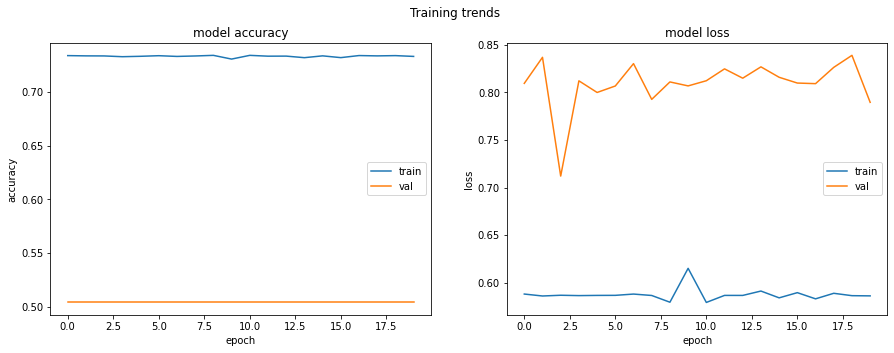

In [70]:
plot_history(history_4)

Configuration: 
- batch size: `64`,
- epochs: `20/20`,
- learning rate: `1e-3`
- encoding units: `300`
- classification units: `128`
- merge mode: `SUM`
- dropout rate: `0.3`
- cosine similarity extension: `True` 
- regularizer: `1e-4`

Obtaining at best `0.5040` accuracy on the validation set.

Then we need to save the model accordingly.

In [71]:
if training:  
  model_4.save(os.path.join(models_path, "model_4"))

  # convert the history.history dict to a pandas DataFrame:     
  df_history_4 = pd.DataFrame(history_4.history) 
  with open(os.path.join(models_path, "history_4.csv"), mode="w") as file:
      df_history_4.to_csv(file)

INFO:tensorflow:Assets written to: models/model_4/assets


INFO:tensorflow:Assets written to: models/model_4/assets


# 6. Evaluation and Inference

At this point we can evaluate the model on the predictions produced by our models.

## 6.1 Multi-Input classification evaluation

In [72]:
def evaluate_predictions(model,
                         X_test,
                         y_test):
  """
  Evaluates given model predictions
  """
  claim_test, evidence_test = X_test
  y_pred = model.predict({"claim": claim_test, "evidence": evidence_test}, batch_size=64)

  print(classification_report(y_test, np.around(y_pred), target_names=['SUPPORTS', 'REFUTES']))
  print()

  conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), labels=[0, 1])
  disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['SUPPORTS', 'REFUTES'])
  fig, ax = plt.subplots(figsize=(6,6))
  disp.plot(ax=ax)

              precision    recall  f1-score   support

    SUPPORTS       0.63      0.92      0.74      3606
     REFUTES       0.84      0.45      0.59      3583

   micro avg       0.68      0.68      0.68      7189
   macro avg       0.73      0.68      0.67      7189
weighted avg       0.73      0.68      0.67      7189
 samples avg       0.68      0.68      0.68      7189




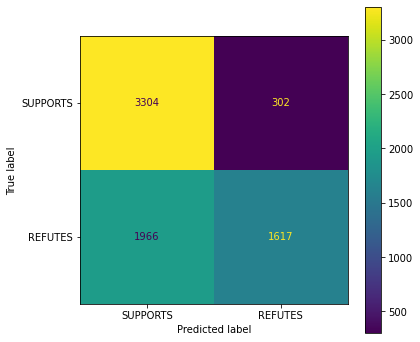

In [73]:
report_multi_1 = evaluate_predictions(model=model_1, X_test=[X_test_claim, X_test_evidence], y_test=Y_test)

              precision    recall  f1-score   support

    SUPPORTS       0.63      0.86      0.73      3606
     REFUTES       0.78      0.50      0.61      3583

   micro avg       0.68      0.68      0.68      7189
   macro avg       0.70      0.68      0.67      7189
weighted avg       0.70      0.68      0.67      7189
 samples avg       0.68      0.68      0.68      7189




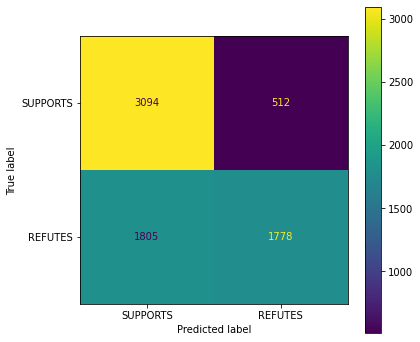

In [74]:
report_multi_2 = evaluate_predictions(model=model_2, X_test=[X_test_claim, X_test_evidence], y_test=Y_test)

              precision    recall  f1-score   support

    SUPPORTS       0.57      0.87      0.69      3606
     REFUTES       0.73      0.35      0.47      3583

   micro avg       0.61      0.61      0.61      7189
   macro avg       0.65      0.61      0.58      7189
weighted avg       0.65      0.61      0.58      7189
 samples avg       0.61      0.61      0.61      7189




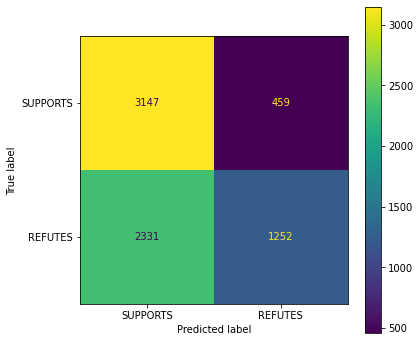

In [75]:
report_multi_3 = evaluate_predictions(model=model_3, X_test=[X_test_claim, X_test_evidence], y_test=Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    SUPPORTS       0.50      1.00      0.67      3606
     REFUTES       0.00      0.00      0.00      3583

   micro avg       0.50      0.50      0.50      7189
   macro avg       0.25      0.50      0.33      7189
weighted avg       0.25      0.50      0.34      7189
 samples avg       0.50      0.50      0.50      7189




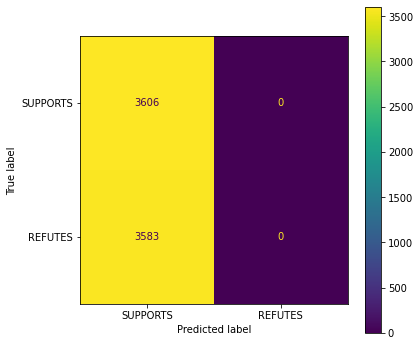

In [76]:
report_multi_4 = evaluate_predictions(model=model_4, X_test=[X_test_claim, X_test_evidence], y_test=Y_test)

## 6.2 Claim Verification evaluation

In [77]:
def compute_majority_votes(claim_list):
    claim_labelled_list = []
    for t in claim_list:
        claim = t[1]
        labels = t[3]
        if(labels.count('SUPPORTS') > labels.count('REFUTES')):
            claim_label = 'SUPPORTS'
        else:
            claim_label = 'REFUTES'
        claim_labelled_list.append(claim_label)

    return claim_labelled_list
  
def grouping_majority_voting(df):
    groupby_id = df.groupby("ID").agg(list)
    groupby_id = groupby_id.reset_index()
    #groupby_claims = groupby_claims.drop(["ID"],axis=1)
    grouped_id_list = groupby_id.values.tolist()
    return compute_majority_votes(grouped_id_list)

def predictions_to_dataframe(df, predictions):
    # Extract predicted one-hot enconded labels 
    df_r = df.copy()
    imax = np.argmax(predictions, axis=1)
    pred_labels = ['SUPPORTS' if i == 0 else 'REFUTES' for i in imax]
    
    df_r = df_r.drop(["Label"], axis=1)
    df_r["Label"] = pd.Series(pred_labels, index=df_r.index)
    return df_r

def claim_verification(model, X_test, y_test, test_claim_list):
  claim_test, evidence_test = X_test
  y_pred = model.predict({"claim": claim_test, "evidence": evidence_test}, batch_size=64)

  predicted_claim_list = grouping_majority_voting(predictions_to_dataframe(df_test, y_pred))
  print(classification_report(test_claim_list, predicted_claim_list, zero_division=0, target_names=['SUPPORTS', 'REFUTES'] ))
  print(f"Macro F1: {f1_score(test_claim_list, predicted_claim_list, average='macro')}")

test_claim_list = grouping_majority_voting(df_test)

In [78]:
claim_verification(model_1, X_test=[X_test_claim, X_test_evidence], y_test=Y_test, test_claim_list=test_claim_list)

              precision    recall  f1-score   support

    SUPPORTS       0.84      0.45      0.59      3304
     REFUTES       0.63      0.92      0.74      3309

    accuracy                           0.68      6613
   macro avg       0.73      0.68      0.66      6613
weighted avg       0.73      0.68      0.66      6613

Macro F1: 0.6646646195453136


In [79]:
claim_verification(model_2, X_test=[X_test_claim, X_test_evidence], y_test=Y_test, test_claim_list=test_claim_list)

              precision    recall  f1-score   support

    SUPPORTS       0.78      0.50      0.61      3304
     REFUTES       0.63      0.86      0.73      3309

    accuracy                           0.68      6613
   macro avg       0.71      0.68      0.67      6613
weighted avg       0.71      0.68      0.67      6613

Macro F1: 0.6677838919743696


In [80]:
claim_verification(model_3, X_test=[X_test_claim, X_test_evidence], y_test=Y_test, test_claim_list=test_claim_list)

              precision    recall  f1-score   support

    SUPPORTS       0.73      0.35      0.48      3304
     REFUTES       0.57      0.87      0.69      3309

    accuracy                           0.61      6613
   macro avg       0.65      0.61      0.58      6613
weighted avg       0.65      0.61      0.58      6613

Macro F1: 0.584588816525156


In [81]:
claim_verification(model_4, X_test=[X_test_claim, X_test_evidence], y_test=Y_test, test_claim_list=test_claim_list)

              precision    recall  f1-score   support

    SUPPORTS       0.00      0.00      0.00      3304
     REFUTES       0.50      1.00      0.67      3309

    accuracy                           0.50      6613
   macro avg       0.25      0.50      0.33      6613
weighted avg       0.25      0.50      0.33      6613

Macro F1: 0.33350131021971374


#9. Summary and discussions

At the end it is possible to see how the first model is the one that provides best results in both training and evaluation phase. So the model having the **Bi-LSTM layers** that takes only the **last state** of them is best while the worst is the **BoV** model.